# HR Analytics: Job Change of Data Scientists -- Predict who will leave

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
hr = pd.read_csv("/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv")

In [ ]:
hr.head(5)

Features
- enrollee_id : Unique ID for enrollee
- city: City code
- citydevelopmentindex: Developement index of the city (scaled)
- gender: Gender of enrolee
- relevent_experience: Relevent experience of enrolee
- enrolled_university: Type of University course enrolled if any
- education_level: Education level of enrolee
- major_discipline :Education major discipline of enrolee
- experience: Employee total experience in years
- company_size: No of employees in current employer's company
- company_type : Type of current employer
- lastnewjob: Difference in years between previous job and current job
- training_hours: training hours completed
- target: 0 – Not looking for job change, 1 – Looking for a job change

# How many candidate seeking a job change?

- 0 – Not looking for job change,
- 1 – Looking for a job change

No of not seeking a job change is far more than those seeking a job change, nearly 3 times. 

In [ ]:
target_count = hr['target'].value_counts()
sns.barplot(target_count.index , target_count.values)
plt.ylabel('Number of candidate')
plt.xlabel('target')

# Male more likely to leave?

Firstly, let's find the ratio of male and female. Most job-seekers appear to be male in terms of absolute no.

However, if look at the pivot table, the mean value (ie ratio of job-seeker) of target between male and female is similar. This is because there are far more male data scientist than female and of course more male job seeker will be observed, giving us a illusion that male employee tend to leave.


In [ ]:
sns.countplot(x="gender", hue="target", data=hr)
plt.ylabel('Number of candidate')

In [ ]:
hr.pivot_table(index=['gender'], values='target',aggfunc=['mean', 'count'])

# How the environment shape their tendency?

I am going to use kdeplot to demostrate the relationship of city development index(CDI) and candidate's tendency of leaving.

This is introduction from seaborn official website for your reference:
- A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. 

Two peaks can be observed: more job-seekers at low CDI scores, while less job-seekers at high CDI scores.

Two possible explanations:
1. Hypothesis: job-seekers are more ambitious.

Usually, large-scale company or company with very high growth locates in city with high CDI, eg San José in Silicon Valley, London in UK. Thus, ppl have less incentives to leave these comapnies, in contrast, ppl in city with low CDI may want to vanish their CVs by seeking a new job

2. Hypothesis: More opportunities in the company located in high CDI scores.

Corportions in high CDI areas should be in larger scale or with well-established date infrastrutture (eg well-built database/ have data team). Employees can find more opportunities or promotion in planning their career path; However, in low CDI areas, company may be in a smaller scale that may not have a team, or still urdergoing digital transformation that data scientist may also take part in data engeering.

The actual reason may also be a mix of above explanations.



In [ ]:
sns.kdeplot(hr.loc[(hr["target"]==0), "city_development_index"], label="Non-Job Seeker")
sns.kdeplot(hr.loc[(hr["target"]==1), "city_development_index"], label="Job Seeker")

# Relationship between experience and training hours

Previously, I assumeed that ppl with more training hours should be more experienced, ie. positively correlated. However, it seems it doesn't have a relationship.

Maybe data scientists still need to self-learn a lot even if they are less-experienced, or the training hour of employee with more experience doesn't equal to the data science skillset training, but total work experience instead.

All of above are just guess since the data dictionary of this dataset doesn't clearly stated. 

In [ ]:
x=hr['experience'].str.strip('><').fillna(0).astype(int)
y=hr['training_hours']
plt.scatter(x, y, marker='o')
plt.ylabel('Training hours')
plt.xlabel('Experience (years)')

# Employee with more training hours more likely to leave?

There can be 2 assumptions beforehand. Employee with more training hours are more skilled, and they are capable of finding better opportunities; Meanwhile, this is also possible that employee with less training hours want to accumulate more experience so they aren't stable once they think they 'learn' enough in that company.

But from the graph, it seems the two interpretations aren't valid either that there is no significant difference between.

In [ ]:
sns.boxenplot(y='training_hours', x='target', data=hr)

# Major of job-seeker

STEM is the majority, either in total no of employee or job-seeker ratio. This feature doesn't tell a big difference as well.

In [ ]:
import matplotlib.gridspec as gridspec

In [ ]:
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(1, 2)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

type_major_0 = hr.loc[hr['target']==0].pivot_table(index='company_type', columns='major_discipline', values='target', aggfunc='count')
type_major_1 = hr.loc[hr['target']==1].pivot_table(index='company_type', columns='major_discipline', values='target', aggfunc='count')


heat_0 = sns.heatmap(ax=ax0, data=type_major_0, cmap="OrRd", cbar=False)
ax0.text(0,-0.5,"Non-job seeker",fontsize=20,fontweight='bold')
heat_1 = sns.heatmap(ax=ax1, data=type_major_1,  yticklabels=False, cmap="OrRd", cbar=False)
ax1.text(1,-0.5,"Job seeker",fontsize=20,fontweight='bold')
ax1.set_ylabel('')  


# No of changing company before

It's obvious that employee who haven't changed company or only once have high likelihood to seek a new job currently.

In [ ]:
total = hr.groupby(['target'])['enrollee_id'].count().reset_index(drop=True)

not_seek = hr.loc[hr['target']==0].groupby(['target','last_new_job'])['enrollee_id'].count().reset_index()
seek = hr.loc[hr['target']==1].groupby(['target','last_new_job'])['enrollee_id'].count().reset_index()

not_seek['percentage'] = not_seek['enrollee_id'].div(total.iloc[0])*100
seek['percentage'] = seek['enrollee_id'].div(total.iloc[1])*100

ax = plt.barh(not_seek.last_new_job, not_seek.percentage, label='Non-job seeker')
ax = plt.barh(seek.last_new_job, seek.percentage, height=0.3, label='Job seeker')

plt.legend()

# Data massage before modelling

In [ ]:
#Finding the ratio of missing values
hr.isna().sum()/len(hr)

In [ ]:
hr_train = hr.fillna(0)

# Introduction of 3 encoding methods

The popular techniques to transform categorical data to numeric input are one-hot encoding, label encoding and ordinal encoding.

Categorical data can further be divided as nominal and ordinal, usually the former is the majority, such as city, gender, major in this dataset. However, an ordering does exist in some categorical data, relevent experience and education level are good examples.

For ordinal variables, ordinal encoding is useful for us to tell the machine which variable is better and which should be ranked higher.

As for nominal variables, ususally one-hot encoding is prefered than label encoding. The difference between one-hot encoding and label encoding is that one-hot encoding will create a binary column for each category in that column, while label encoding encode target  with value between 0 and n-1. Thus, if there are hundreds features in that column, 100 binary columns will be created by one-hot encoding and only one columns will be created in label encoding.

Using label encoding may mislead the machine that there is an ordering between categories. The application of label encoding is commonly found to encode the labels, as its name stated (Official definition from sklearn: Encode target labels with value between 0 and n_classes-1, used to transform non-numerical labels to numerical labels. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) 

But if there are 100 categories in one feature, 99 new input vector will then be created which sounds intimidating, but the models can generally handle it in case the instances are far more than the features.

To conclude, there is no one-size-sit-all or standard encoding method, it just depends on the dataset and the chosen model.

![](https://docs.microsoft.com/en-us/dotnet/machine-learning/media/model-builder-data.png)

Fig 1. Terms used when describing the dataset, rows are sometimes called as instances.
(Source from: https://docs.microsoft.com/en-us/dotnet/machine-learning/automate-training-with-model-builder)

# Ordinal encoding

Let's get started with ordinal variables: relevent_experience, enrolled_university, education_level, company_size

As there is no missing value of "relevent_experience", and there is just 2 variables: has or hasn't. I just simply transform them into 0,1. 

In [ ]:
hr_train['relevent_experience'].unique()

In [ ]:
hr_train['relevent_experience'] = hr_train['relevent_experience'].replace('Has relevent experience',1)
hr_train['relevent_experience'] = hr_train['relevent_experience'].replace('No relevent experience',0)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
hr_train.company_size.unique()

In [ ]:
#The missing values are replaced with 0 abovehead, need to include 0 in the order list though it is numeric

edu_lv = [0,'Primary School','High School','Graduate','Masters','Phd']
uni = [0,'no_enrollment', 'Part time course', 'Full time course']
comp_size = [0,'<10','10/49','50-99','100-500','500-999','1000-4999','5000-9999','10000+']

In [ ]:
enc = OrdinalEncoder(categories=[uni])

In [ ]:
ordi1 = pd.DataFrame(enc.fit_transform(hr_train[["enrolled_university"]]))

In [ ]:
#rename column for easy understanding
ordi1 = ordi1.rename(columns={0:"University"})

In [ ]:
#Repeat ordinal encoding for education level and company_size
enc = OrdinalEncoder(categories=[edu_lv])
ordi2 = pd.DataFrame(enc.fit_transform(hr_train[["education_level"]]))

In [ ]:
ordi2 = ordi2.rename(columns={0:"Education level"})

In [ ]:
enc = OrdinalEncoder(categories=[comp_size])
ordi3 = pd.DataFrame(enc.fit_transform(hr_train[["company_size"]]))
ordi3 = ordi3.rename(columns={0:"Company size"})

# One-hot encoding

In [ ]:
hr_train= pd.get_dummies(hr_train, columns=['gender', 'major_discipline', 'company_type'])

In [ ]:
#check any string in the columns
from pandas.api.types import is_numeric_dtype

In [ ]:
is_numeric_dtype(hr_train['city_development_index'])

In [ ]:
is_numeric_dtype(hr_train['training_hours'])

In [ ]:
hr_train.experience.unique()

In [ ]:
#Simply transform >20 to 21, of course it may be underestimated
#Simply transform <1 to 0.5 as the mean
hr_train['experience'] = hr_train['experience'].replace('>20',21)
hr_train['experience'] = hr_train['experience'].replace('<1',0.5)

In [ ]:
hr_train.last_new_job.unique()

In [ ]:
hr_train['last_new_job'] = hr_train['last_new_job'].replace('>4',5)
hr_train['last_new_job'] = hr_train['last_new_job'].replace('never',0)

It's quite embarrassing for column "city" as there is 123 unique cities. Let's simply do label encoding to have only one column

In [ ]:
len(hr_train.city.unique())

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
hr_train['city'] = LabelEncoder().fit_transform(hr_train['city'])

In [ ]:
hr_train = hr_train.drop(columns=['enrollee_id',
                       'enrolled_university',
                       'education_level',
                       'company_size',
                      'target'])

In [ ]:
hr_train

In [ ]:
#concat all features
X = pd.concat([hr_train, ordi1, ordi2, ordi3], axis=1)

# TSNE

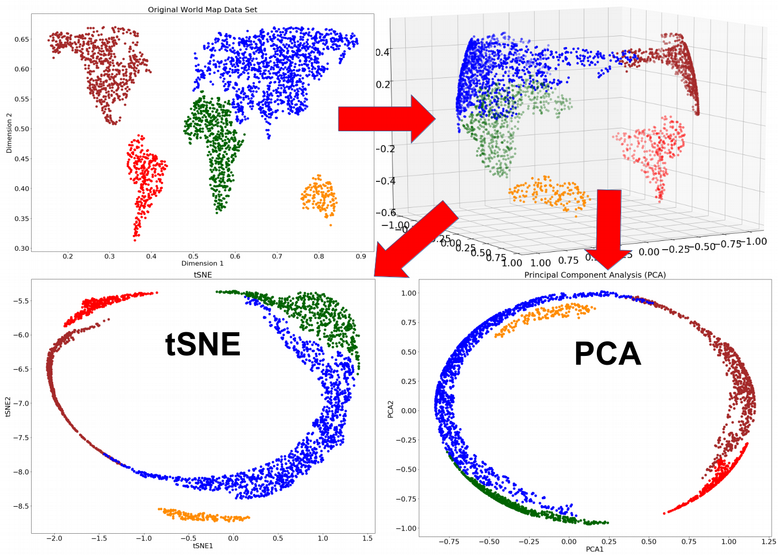

Fig 2. dimensionality reduction by tSNE & PCA
(Source from: https://towardsdatascience.com/tsne-degrades-to-pca-d4abf9ef51d3)

TSNE (t-distributed stochastic neighbor embedding)
- visualizing high-dimensional data
- nonlinear dimensionality reduction technique

Step:
- determine the 'similarity' of all points
- scale the unscaled similarities that they add up to 1

why t-distribution?
- normal distribution alike
- but isn't as tall in the middle and the tails are taller on the ends

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
#Dimension of the embedded space
X_embedded = TSNE(n_components=2).fit_transform(X)

In [ ]:
X_embedded.shape

In [ ]:
df = pd.DataFrame()
df["y"] = hr['target']
df["dim-1"] = X_embedded[:,0]
df["dim-2"] = X_embedded[:,1]

In [ ]:
sns.scatterplot(x="dim-1", y="dim-2", hue=df.y.tolist(),
                data=df).set(title="T-SNE projection") 

Job-seeker and non-job seeker literally mix together

# Modelling

Support Vector Machine (SVM)
- supervised machine learning
- optimal decision boundary --> maximum margin from the nearest points of all the classes
- soft margin --> distance between observations and threshold --> allow some misclassifications
- observations within soft margin --> support vectors
- find support vector classifiers by kernel functions
- classify observations in higher dimensions by hyperplane
- kernal trick --> calculate high-dimensional relationships without actually transforming the data to higher dimension

![](https://i2.wp.com/techvidvan.com/tutorials/wp-content/uploads/sites/2/2020/05/Support-Vector-Machines-1.jpg?ssl=1)

Fig 3. Support vector machine
(Source from: https://techvidvan.com/tutorials/svm-in-r/)

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_svc_001.png)

Fig 4. Demonstration of different kernel (Source from: https://scikit-learn.org/stable/modules/svm.html)

In [ ]:
from sklearn.svm import SVC

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, hr['target'], test_size = 0.2, random_state=46)

# 1. Linear kernel

In [ ]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

In [ ]:
y_pred_lin = svclassifier.predict(X_val)

# 2. Polynomial kernel

In [ ]:
svclassifier = SVC(kernel='poly', degree=3)
svclassifier.fit(X_train, y_train)
y_pred_poly = svclassifier.predict(X_val)

# 3. RBF kernel

In [ ]:
#Default: rbf
svclassifier = SVC()
svclassifier.fit(X_train, y_train)
y_pred_rbf = svclassifier.predict(X_val)

# Evaluation

# 1. Linear kernel performance

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val,y_pred_lin))
print(classification_report(y_val,y_pred_lin))

# 2. Polynomial kernel performance

In [ ]:
print(confusion_matrix(y_val,y_pred_poly))
print(classification_report(y_val,y_pred_poly))

# 3. RBF kernel performance

In [ ]:
print(confusion_matrix(y_val,y_pred_rbf))
print(classification_report(y_val,y_pred_rbf))

Without changing the C parameter, accuracy remains same in different kernels.
Let's change the C parameter and see if any difference.

# 4. RBF with different values on C parameter

When C=211, the accuracy rise 1%, while when C=311, the accuracy rise to 77%

In [ ]:
# start with small C
for i in range(3,10):
    svclassifier = SVC(C=i)
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_val)
    print('RBF with C={}'.format(i))
    print(classification_report(y_val,y_pred))

In [ ]:
#Seem small C doesn't make a big difference, Try bigger C with larger interval to save time
for i in range(11,511,100):
    svclassifier = SVC(C=i)
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_val)
    print('RBF with C={}'.format(i))
    print(classification_report(y_val,y_pred))